In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward


import copy

plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

In [2]:

def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y, n_h) * 0.01 
    b2 = np.zeros((n_y,1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

In [3]:

def initialize_parameters_deep(layer_dims):

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):

        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))

        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [4]:

def linear_forward(A, W, b):

    Z = np.dot(W,A) +b
    cache = (A, W, b)
    
    return Z, cache

In [5]:

def linear_activation_forward(A_prev, W, b, activation):

    if activation == "sigmoid":

        Z, linear_cache = linear_forward(A_prev,W ,b)
        A , activation_cache = sigmoid(Z)

    elif activation == "relu":

        Z, linear_cache = linear_forward(A_prev, W ,b)
        A , activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

In [6]:

def L_model_forward(X, parameters):


    caches = []
    A = X
    L = len(parameters) // 2                 
    for l in range(1, L):
        A_prev = A 

        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A,  parameters["W"+str(L)], parameters["b"+str(L)], "sigmoid")
    caches.append(cache)

    return AL, caches

In [7]:

def compute_cost(AL, Y):

    m = Y.shape[1]
    cost = (np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log((1-AL)).T))/-m
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).

    
    return cost

In [8]:

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (np.dot(dZ, A_prev.T))/m
    db = np.sum(dZ,axis=1, keepdims=True)/m
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [9]:

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":

        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "sigmoid":
 
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [10]:

def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    dAL =  - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1] # Last Layer
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")

    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):

        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
 
    return grads

In [11]:

def update_parameters(params, grads, learning_rate):
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):

        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)] #- (learning_rate*lambd/m)*parameters["W" + str(l+1)] regularization
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

In [15]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))

    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [12]:
from dnn_app_utils_v3 import *

In [16]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [17]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [18]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [19]:

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims

    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        cost = compute_cost(A2, Y)
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")

        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2

        parameters = update_parameters(parameters, grads,learning_rate)
        

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.4007977536203887
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.33942815383664127
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.2749137728213016
Cost after iteration 1300: 0.24681768210614832
Cost after iteration 1400: 0.19850735037466086
Cost after iteration 1500: 0.17448318112556682
Cost after iteration 1600: 0.1708076297809607
Cost after iteration 1700: 0.11306524562164731
Cost after iteration 1800: 0.09629426845937152
Cost after iteration 1900: 0.08342617959726861
Cost after iteration 2000: 0.0743907870431908
Cost after iteration 2100: 0.0663074813

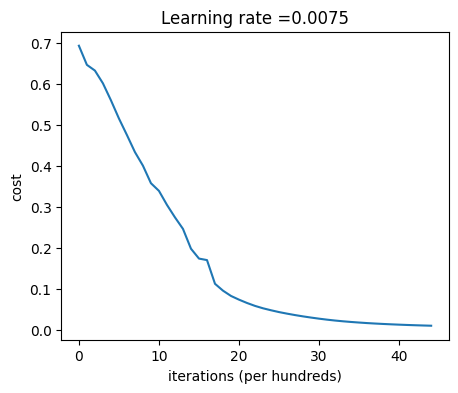

In [21]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 4500, print_cost=True)
plot_costs(costs, learning_rate)

In [25]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.7000000000000001


In [24]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


 4 Layer network implemented below

In [26]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [27]:

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)

        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [29]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 4500, print_cost = True)

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822914
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.5670473268366111
Cost after iteration 500: 0.5401376634547801
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.4654773771766851
Cost after iteration 800: 0.36912585249592794
Cost after iteration 900: 0.39174697434805344
Cost after iteration 1000: 0.31518698886006163
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.23741853400268137
Cost after iteration 1300: 0.19960120532208647
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.16118854665827748
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.1297401754919012
Cost after iteration 1900: 0.12122535068005212
Cost after iteration 2000: 0.11382060668633712
Cost after iteration 2100: 0.107839

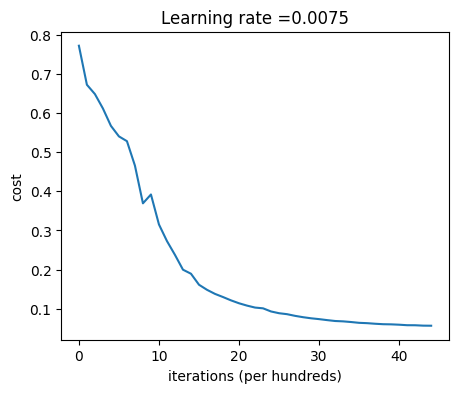

In [30]:
plot_costs(costs, learning_rate)

In [31]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.78


In [32]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9904306220095691
